# Autograd: automatic differentiation

The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

In [1]:
import torch

Create a tensor:

In [2]:
# Create a 2x2 tensor with gradient-accumulation capabilities
x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


Do an operation on the tensor:

In [3]:
# Deduct 2 from all elements
y = x - 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [4]:
print(y.grad_fn)

In [5]:
# What's happening here?
print(x.grad_fn)

None


In [6]:
x

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [7]:
# Let's dig further...
y.grad_fn

In [8]:
y.grad_fn.next_functions[0][0]

In [9]:
y.grad_fn.next_functions[0][0].variable

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [10]:
y.grad_fn.next_functions

((<AccumulateGrad at 0x7fe75ba59520>, 0), (None, 0))

In [11]:
y.grad_fn.next_functions[0][0].variable is x

True

In [12]:
y.grad_fn.next_functions[0]

(<AccumulateGrad at 0x7fe75ba59520>, 0)

In [13]:
y.grad_fn.next_functions[0][0]

In [14]:
# Do more operations on y
z = y * y * 3
a = z.mean()  # average

print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [15]:
# Let's visualise the computational graph! (thks @szagoruyko)
from torchviz import make_dot

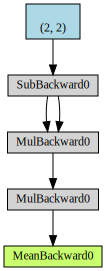

In [16]:
make_dot(a)

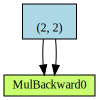

In [17]:
make_dot(x*x)

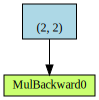

In [18]:
make_dot(1.5*x)

## Gradients

Let's backprop now `out.backward()` is equivalent to doing `out.backward(torch.tensor([1.0]))`

In [19]:
# Backprop
a.backward()

**(?1)**
Please solve this prolem of `Found no NVIDIA driver`

`cpuonly` package is needed. cf. the edited `environment.yml`

Print gradients $\frac{\text{d}a}{\text{d}x}$.

In [20]:
# Compute it by hand BEFORE executing this
print(x.grad)

tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])


**(?2)** Deduce the same numbers/result by hand calculating

**(R2)**
![](figs/note-autodiff.jpg)

You can do many crazy things with autograd!
> With Great *Flexibility* Comes Great Responsibility

In [21]:
# Dynamic graphs!
x = torch.randn(3, requires_grad=True)

y = x * 2
i = 0
while y.data.norm() < 1000:
    # frobenius norm, i.e. matrix viewed as vector
    # enfin, je me corrige, ici il s'agit du 2-norme du vecteur y
    y = y * 2
    # at each iteration, we double the length of the vector y
    i += 1
print(y)

tensor([-570.3732, -849.9706, -206.6821], grad_fn=<MulBackward0>)


In [22]:
# If we don't run backward on a scalar we need to specify the grad_output
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)

print(x.grad)

tensor([5.1200e+01, 5.1200e+02, 5.1200e-02])


**(?3)** What does it mean to have `y.backward(gradients)`?

**(R3)**
A function
$f: \quad
\begin{align}
  \mathbb{R}^{n} &\to \mathbb{R}^{m} \\
  (x_1,x_2,\ldots,x_n) &\mapsto (y_1,y_2,\ldots,y_m) \\
\end{align}
$
admits jacobian

$$
\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}.
$$

Loosely speaking, when we have a vector $\mathbf{v} = \left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$, **gradient of some scalar function** $l: \mathbb{R}^{m} \to \mathbb{R}$, the gradient of the composite function $l \circ f$ equals
$$
J^{T} \mathbf{v} =
\begin{align}\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}
\begin{pmatrix}
  \frac{\partial l}{\partial y_{1}} \\
  %\frac{\partial l}{\partial y_{2}} \\
  \vdots \\
  \frac{\partial l}{\partial y_{m}} \\
\end{pmatrix}.
$$

To answer the question, `y.backward(gradients)` returns $J^{T} \mathbf{v}$, where $J$ is the jacobian (of `y` as a function of `x`) and $\mathbf{v} =$ `gradients`.

#### Let's check this with `x.grad`
The jacobian in this case is $\left(y_{i} = 2^{k} x_{i}\quad\forall\;\; i=1,2,3\right)$

$$
J = \begin{pmatrix}
2^{k} & 0     & 0 \\
0     & 2^{k} & 0 \\
0     & 0     & 2^{k} \\
\end{pmatrix}.
$$

With $v = \begin{pmatrix} 0.1 \\ 1.0 \\ 0.0001 \end{pmatrix}$, we have $J^{T} v = \begin{pmatrix} 0.1\times 2^{k} \\ 1.0 \times 2^{k} \\ 0.0001 \times 2^{k} \end{pmatrix}.$

In [23]:
# BEFORE executing this, can you tell what would you expect it to print?
print(i)

8


In [24]:
x

tensor([-1.1140, -1.6601, -0.4037], requires_grad=True)

In [25]:
y.data.norm?

Signature: y.data.norm(p='fro', dim=None, keepdim=False, dtype=None)
Docstring: See :func:`torch.norm`
File:      ~/.config/miniconda3/envs/pDL/lib/python3.8/site-packages/torch/tensor.py
Type:      method


## Inference

In [26]:
# This variable decides the tensor's range below
n = 3

In [27]:
# Both x and w that allows gradient accumulation
x = torch.arange(1., n + 1, requires_grad=True)
w = torch.ones(n, requires_grad=True)
z = w @ x  # inner product of two vectors w and x
z.backward()
print(x.grad, w.grad, sep='\n')

tensor([1., 1., 1.])
tensor([1., 2., 3.])


In [28]:
z

tensor(6., grad_fn=<DotBackward>)

In [29]:
# Only w that allows gradient accumulation:
# By default, requires_grad=False.
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

None
tensor([1., 2., 3.])


In [30]:
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)

# Regardless of what you do in this context, all torch tensors will not have gradient accumulation
with torch.no_grad():
    z = w @ x

try:
    z.backward()  # PyTorch will throw an error here, since z has no grad accum.
except RuntimeError as e:
    print('RuntimeError!!! >:[')
    print(e)

RuntimeError!!! >:[
element 0 of tensors does not require grad and does not have a grad_fn


## More stuff

Documentation of the automatic differentiation package is at
http://pytorch.org/docs/autograd.